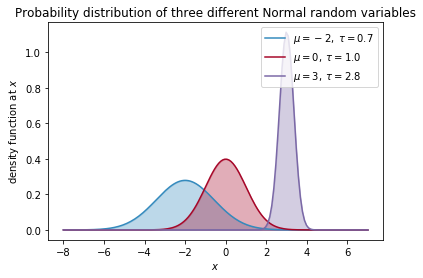

In [4]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

nor = stats.norm
x = np.linspace(-8, 7, 150)
mu = (-2, 0, 3)
tau = (.7, 1, 2.8)
colors = ["#348ABD", "#A60628", "#7A68A6"]
parameters = zip(mu, tau, colors)

for _mu, _tau, _color in parameters:
    plt.plot(x, nor.pdf(x, _mu, scale=1./_tau),
             label="$\mu = %d,\;\\tau = %.1f$" % (_mu, _tau), color=_color)
    plt.fill_between(x, nor.pdf(x, _mu, scale=1./_tau), color=_color,
                     alpha=.33)

plt.legend(loc="upper right")
plt.xlabel("$x$")
plt.ylabel("density function at $x$")
plt.title("Probability distribution of three different Normal random \
variables");


In [12]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

X, y = make_friedman1(n_samples=1200, random_state=0, noise=1.0)
X_train, X_test = X[:200], X[200:]
y_train, y_test = y[:200], y[200:]
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.2, 
                                max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)
mean_squared_error(y_test, est.predict(X_test))    

3.89600475532934

In [68]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "loss":["ls"],
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 3),
    "min_samples_leaf": np.linspace(0.1, 0.5, 3),
    "max_depth":[1,3,5,8],
    #"max_features":["log2","sqrt"],
    #"criterion": ["friedman_mse",  "mae"],
    "subsample":[0.25,0.5, 0.75, 1.0],#[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10,100,500]
    }

In [69]:
import datetime

dt0=datetime.datetime.now()
clf = GridSearchCV(GradientBoostingRegressor(), parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.best_params_)
print(datetime.datetime.now()-dt0)

0.995512991915
{'learning_rate': 0.2, 'loss': 'ls', 'max_depth': 5, 'min_samples_leaf': 0.10000000000000001, 'min_samples_split': 0.5, 'n_estimators': 500, 'subsample': 0.75}
0:10:05.249716


In [78]:
def frame_cv_results(clf):
    df_cv=pd.DataFrame()

    for i in range(len(clf.cv_results_['params'])):
        df_cv=df_cv.append(clf.cv_results_['params'][i],ignore_index=True)

    metrics=['mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score']

    for metr in metrics:
        df_cv[metr]=clf.cv_results_[metr]
    return df_cv

In [80]:
def plot_cv_results(df_cv,clf):
    key_list=list(clf.param_grid.keys()-{'loss'})
    fig, axs = plt.subplots(int(np.ceil(len(key_list)/4)),4, 
                            figsize=(20, int(3*np.ceil(len(key_list)/4))), 
                            facecolor='w', edgecolor='k')
    #fig.subplots_adjust(hspace = .5, wspace=.001)

    axs = axs.ravel()
    plt.setp(axs, yticks=np.linspace(0,1,6))
    for i , key in enumerate(key_list):
        summary=df_cv[[key,'mean_test_score','mean_train_score']] \
                    .groupby([key]).agg([np.median,percentile(5),percentile(95),
                                                    percentile(25),percentile(75)])
        axs[i].plot(summary[('mean_test_score','median')],label='Test: Median & 25-75/5-95 range')

        axs[i].fill_between(list(summary.index), 
                            summary[('mean_test_score','percentile_25')],
                            summary[('mean_test_score','percentile_75')], 
                            color="#348ABD", alpha=.33)

        axs[i].fill_between(list(summary.index), 
                            summary[('mean_test_score','percentile_5')],
                            summary[('mean_test_score','percentile_95')], 
                            color="#348ABD", alpha=.1)
        
        axs[i].plot(summary[('mean_train_score','median')],label='Test: Median & 25-75/5-95 range')

        axs[i].fill_between(list(summary.index), 
                            summary[('mean_train_score','percentile_25')],
                            summary[('mean_train_score','percentile_75')], 
                            color="#A60628", alpha=.33)

        axs[i].fill_between(list(summary.index), 
                            summary[('mean_train_score','percentile_5')],
                            summary[('mean_train_score','percentile_95')], 
                            color="#A60628", alpha=.1)
        
        axs[i].set_title(key)
        axs[i].set_ylim([0,1])
        if i == len(key_list)-1:
            axs[i].legend()

def percentile(n):
    def percentile_(x):
        return np.percentile(x,n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

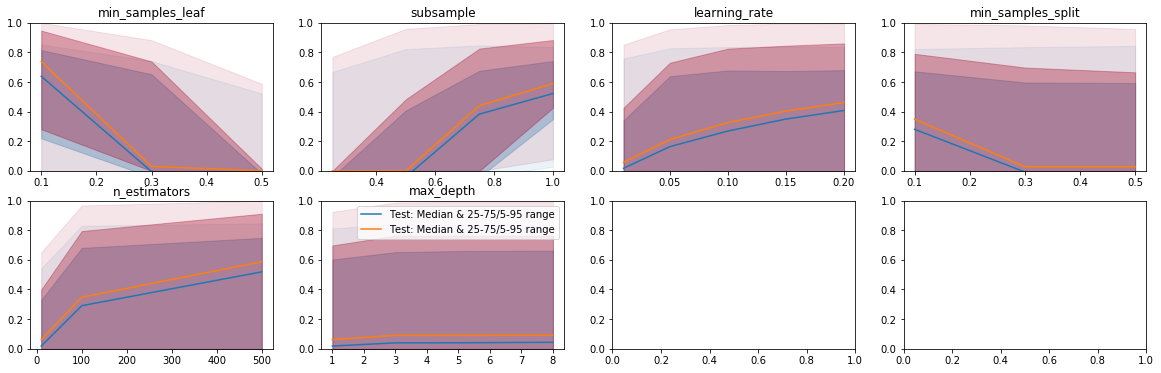

In [81]:
cv_results=frame_cv_results(clf)
plot_cv_results(cv_results,clf)

In [83]:
PATH_PARAMETER_FILE = 'ML_PARAMETER_FILE.txt'

In [84]:
def update_params(call,fields,params,control_vars,filename=PATH_PARAMETER_FILE):
    import os
    import json
    exists = os.path.isfile(filename)
    if exists:
        with open(filename) as ff:
            pipe_params = json.load(ff)['key']
        pipe_params = pipe_params + [{'fn_call':call, 'fields': fields,
                                     'params':params, 'control_vars': control_vars}]
    else:
        pipe_params = [{'fn_call':call, 'fields': fields,
                                     'params':params, 'control_vars': control_vars}]
        
    with open(filename, 'w') as ff:
        json.dump({'key': pipe_params}, ff)
        
def show_params(filename=PATH_PARAMETER_FILE):
    import os
    import json
    exists = os.path.isfile(filename)
    if exists:
        with open(filename) as ff:
            pipe_params = json.load(ff)['key']
    else:
        pipe_params = []
        print('Parameter file empty')
    return pipe_params

def clear_pipe(filename = PATH_PARAMETER_FILE):
    import os
    exists = os.path.isfile(filename)
    if exists:
        os.remove(filename)
    else:
        1

In [87]:
def feat_cat_freq(df,fields,feat_freq,track=False,filename=PATH_PARAMETER_FILE):
    # generate categories based on a maximum number of categories desired, selecting only the most common ones
    # if feat_freq < 1 value is considered to be a percentage of all
    out = df.copy()
    fields = fields if type(fields) == list else list(fields)
    for sel_fld in fields:
        # select categories to convert
        if feat_freq < 1:
            coverage = int(feat_freq*len(out))
            nr_cats = int(min(sum(~(out[sel_fld].value_counts().cumsum()>coverage))+1,len(out)))
            select_cats = list(out[sel_fld].value_counts().index[:nr_cats])
        else:
            nr_cats = feat_freq
            select_cats = list(out[sel_fld].value_coounts().index[:nr_cats])
        other_cats = list(set(out[sel_fld].values)-set(select_cats))
        
        out[sel_fld]=out[sel_fld].apply(lambda x: x if x in select_cats else 'other')
        
        df_one_hot = pd.get_dummies(out[[sel_fld]])
        save_params = {'select_cats':select_cats,'other_cats': other_cats}
        control_vars = {'perc_select': sum(out[sel_fld].isin(select_cats)) / len(out[sel_fld]),
                        'tail_length': len(other_cats)}
        
        out=pd.concat([out,df_one_hot],axis=1)
        out=out.drop(sel_fld,axis=1)
        
        if track:
            update_params(call='feat_cat_freq',
                         fields=sel_fld,
                         params=save_params,
                         control_vars=control_vars,
                         filename=filename)
        print('Field: ' + sel_fld + ': Categorical Selection - ' \
             ' Cover: ' + str(round(control_vars['perc_select'],3)) + \
             ', # selected: ' + str(len(select_cats)) + \
             ', # other: ' + str(len(other_cats)))
    return out    

In [88]:
def feat_num_scale_minmax(df, fields, track=False, filename = PATH_PARAMETER_FILE):
    fields = fields if type(fields) == list else list(fields)
    out = df.copy()
    for sel_fld in fields:
        min_srs = out[sel_fld].describe().loc['min']
        max_srs = out[sel_fld].describe().loc['max']
        avg_srs = out[sel_fld].describe().loc['mean']
        
        rng = max_srs - min_srs
        
        out[srs_fld] = (out[sel_fld] + min_srs) / rng
        if track:
            update_params(call='feat_num_scale_minmax',
                         fields = sel_fld,
                         params = {'range': rng, 'lower': min_srs},
                         cotrol_vars = {'min': min_srs, 'mean': avg_srs, 'max': max_srs},
                         filename = filename)
        print('Field: ' + sel_fld + ': Numerical MinMax - min/max range: ' + 
             str(int(min_srs)) + '-' + str(int(max_srs)))
        return out

In [89]:
def feat_select(df, fields, track=False, filename=PATH_PARAMETER_FILE):
    if track:
        update_params(call='feat_select',
                     fields = fields,
                     params = {},
                     control_vars = {},
                     filename = filename)
    return df[fields]

In [90]:
def feat_call_pipeline(df, pipe_parameters):
    out=df.copy()
    for params in pipe_parameters:
        if params['fn_call'] == 'feat_cat_freq':
            out[params['fields']]=out[params['fields']].apply(lambda x: x
                                                             if x in params['params']['select_cats']
                                                             else 'other')
            df_one_hot=pd.get_dummies(out[[params['fields']]])
            
            # Builds categories from teh selected list
            col_nm_sel_cats = [str(params['fields']) + '_' + str(col_nm) for col_nm in params['params']['select_cats']]
            if len(params['params']['other_cats'])>0:
                col_nm_sel_cats = col_nm_sel_cats + [str(params['fields']) + '_' + str('other')]
                
            df_one_hot = df_one_hot.reindex(columns = col_nm_sel_cats, fill_value=0)
            out=pd.concat([out,df_one_hot],axis=1)
            out=out.drop(params['fields'],axis=1)
            
        elif params['fn_call'] == 'feat_num_scal_minmax':
            out[params['fields']] = (out[params['fields']] - params['params']['lower']) / params['params']['range']
        elif params['fn_call'] == 'feat_select':
            out=out[params['fields']]
    return out